# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. 

## Изучение данных из файла

In [1]:
# импортируем необходимые нам библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#прочитаем файлы
try:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    df_arc = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_arc.csv')
    df_bulk = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_bulk.csv')
    df_bulk_time = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_bulk_time.csv')
    df_gas = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_gas.csv')
    df_temp = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_temp.csv')
    df_wire = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_wire.csv')
    df_wire_time = pd.read_csv(r'C:\Users\User\Downloads\final_steel\data_wire_time.csv')

In [3]:
# создадим функцию которая выведет информацию о данных в столбцах таблицы
def column_info(df):
    print('\033[1m'+'Пропуски:'+'\033[0m')
    print(df.isna().sum())
    print('*'*52)
    print()
    print('\033[1m'+'Количество дубликатов:'+'\033[0m', df.duplicated().sum())
    print('*'*52)
    print()
    print('\033[1m'+'Общая информация'+'\033[0m')
    print(df.info())
    print('*'*52)

In [4]:
# создадим функцию которая выведет информацию о самих данных в таблице
def data_info(df):
    display(df.head())
    display(df.tail())
    print('\033[1m'+'Уникальные значения столбцов'+'\033[0m')
    for column in df.columns:
        print('\033[1m'+column+':'+'\033[0m', df[column].sort_values().unique())

In [5]:
# посмотрим на значения данных в столбцах таблицы df_arc 
column_info(df_arc)

Пропуски:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
****************************************************


В таблице **df_arc** 
- Пропуски отсутствуют.
- Явных дубликатов нет
- Имеем три типа данных int64, object, float64
- Имеем нарушения стиля (заглавные буквы, не используется змеиный регистр, кириллица)

In [6]:
# посмотрим на значения данных в таблицы df_arc 
data_info(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Начало нагрева дугой: ['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-01 04:16:41' '2019-09-01 04:31:51' '2019-09-01 04:34:47']
Конец нагрева дугой: ['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-01 04:19:45' '2019-09-01 04:32:48' '2019-09-01 04:36:08']
Активная мощность: [0.03000194 0.03018816 0.0301905  ... 3.15076178 3.15627646 3.73159611]
Реактивная мощность: [-7.15504924e+02  2.08063126e-02  2.11541653e-02 ...  2.45995915e+00
  2.50420606e+00  2.67638755e+00]


- В столбцах **Начало нагрева дугой** и **Конец нагрева дугой** необходимо заменить тип данных с object на date.
- Уникальные значения в столбцах подозрений не вызывают. За исключением того, что есть отрицательное значение в реактивной мощности. Мне кажется, что вроде бы как, она может быть отрицательной и поиск в интернете говорит об этом же. Но может ли она быть отрицательной в наших условиях? да и один случай на тысячи значений..., думаю, можно смело кикнуть эту запись. А лучше даже, наверное, все значения по этому ключу. Раз есть одна аномалия, то возможно есть и вторая, а возможно даже и третья, просто мы их например не видим.
- Так как у нас есть данные о активной и реактивной мощности, то  можно найти полную мощность.
- Тип данных столбца **key**, **Активная мощность** и **Реактивная мощность** оставим без изменений
- Переименуем столбцы **'Начало нагрева дугой'**, **'Конец нагрева дугой'**, **'Активная мощность'** и **'Реактивная мощность'**

In [7]:
# посмотрим более подробно данные о партии №2116
key_bad = int(df_arc[df_arc['Реактивная мощность'] < 0]['key'])
df_arc[df_arc['key'] == key_bad]


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Ну тут явно что-то не то с отрицательным значением. Вроде бы как остальные данные по Реактивной мощности похожи на правду, то, наверное, их оставим.

In [8]:
# удалим строку с отрицательным значением в реактивной мощности 
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]

In [9]:
# посмотрим на значения данных в столбцах таблицы df_bulk
column_info(df_bulk)

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bul

В таблице **df_bulk**
- Присуттвует достаточное количество пропусков.
- Явных дубликатов нет
- Имеем два типа данных int64 и float64
- Имеем нарушения стиля (не используется змеиный регистр)

In [10]:
# посмотрим на значения данных в таблице df_bulk
data_info(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Bulk 1: [ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Bulk 2: [228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Bulk 3: [  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131.

Пропуски в значениях подачи сыпучих материалов, это означает, что для какого-то тех процесса они не нужны? или это всё же потери информации? Я пока склоняюсь к тому, что скорее всего это разные тех процессы, но станет более ясно после более подробного ознакомления с тех процессом. 

- Во всех столбцах тип данных нас пока устраивает.
- Уникальные значения во всех столбцах пока подозрений не вызывают. Ящик с усами строить, наверное, бессмысленно, так как мы не знаем тех процесс и выброс по размаху может вполне оказаться редким тех. процессом. 
- Переименуем столбцы с нарушением стиля.

In [11]:
# посмотрим на значения данных в столбцах таблицы df_bulk_time
column_info(df_bulk_time)

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 no

В таблице **df_bulk_time**
- Присуттвует пропуски в том же количестве и месте как в таблице df_bulk, что навернео логично, есть подача, есть и фиксация этого вермени. 
- Явных дубликатов нет
- Имеем два типа данных int64 и object
- Имеем нарушения стиля (не используется змеиный регистр)

In [12]:
# посмотрим на значения данных в таблице df_bulk_time
data_info(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Bulk 1: ['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52:57' '2019-05-16 01:41:04' '2019-

- Во всех столбцах кроме key необходимо заменить тип данных на date.
- Уникальные значения во всех столбцах подозрений не вызывают. На вскидку, везде где есть подача сыпучих материалов, есть и время их подачи. Так что скорее всего где стоит NaN, это означает, что этот сыпучий материал не нужен для тех. процесса.  
- Можно провести проверку на соответствие, и если где-то будет стоять объём, а не будет времени, то наверное можно кикнуть эту запись.
- Переименуем столбцы с нарушением стиля.

In [13]:
# посмотрим на значения данных в столбцах таблицы df_gas
column_info(df_gas)

Пропуски:
key      0
Газ 1    0
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
****************************************************


В таблице **df_gas**
- Пропуски отсутствуют. 
- Явных дубликатов нет
- Имеем два типа данных int64 и float64
- Имеем нарушения стиля (не используется змеиный регистр, кириллица)

In [14]:
# посмотрим на значения данных в таблице df_gas
data_info(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Газ 1: [8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


- Типы данных изменять не будем.
- По аналогии с сыпучими материалами, уникальные значения пока подозрений не вызывают.
- Переименуем столбцы с нарушением стиля.

In [15]:
# посмотрим на значения данных в столбцах таблицы df_temp
column_info(df_temp)

Пропуски:
key                0
Время замера       0
Температура     2901
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
****************************************************


В таблице **df_temp**
- Присутствуют пропуски в столбце **Температура** и это около 18% информации. 
- Явных дубликатов нет
- Имеем три типа данных int64, object и float64
- Имеем нарушения стиля (не используется змеиный регистр, кириллица)

In [16]:
# посмотрим на значения данных в таблице df_temp
data_info(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Время замера: ['2019-05-03 11:16:18' '2019-05-03 11:25:53' '2019-05-03 11:29:11' ...
 '2019-09-01 04:22:39' '2019-09-01 04:33:42' '2019-09-01 04:38:08']
Температура: [1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627. 1628. 1629. 1630. 1631. 1632. 1633. 1634. 1635. 1636.
 1637. 1638. 1639. 1640. 1641. 164

- В столбце **Время замера** необходимо заменить тип данных с object на date.
- Уникальные значения по аналогии, пока подозрений не вызывают. Хотя поисковик выдает, что температура плавления стали находится в диапазоне от 1350 до 1535°С, то первые 5 значений можно было бы удалить. Но с другой стороны, мы же не знаем какой металл заливают изначально, может быть у него и такая температура плавления. Если это первая температура по ключу тогда думаю ее можно будет оставить. 
- В столбце **Температура** NaN-ы стоит удалить, так как это наш целевой признак. 
- Тип данных столбца **key**, **Активная мощность** и **Реактивная мощность** оставим без изменений
- Переименуем столбцы с нарушением стиля.

In [17]:
# узнаем какие по счету температуры 1191, 1204, 1208, 1218, 1227
suspicious_temp = [1191, 1204, 1208, 1218, 1227]
suspicious_key = []
for temp in suspicious_temp:
    display(df_temp[df_temp['key'] == int(df_temp[df_temp['Температура'] == temp]['key'])])


,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0


,key,Время замера,Температура
12564,2561,2019-08-08 07:34:15,1204.0
12565,2561,2019-08-08 07:35:02,NaN
12566,2561,2019-08-08 07:35:38,NaN
12567,2561,2019-08-08 07:49:07,NaN
12568,2561,2019-08-08 07:54:21,NaN
12569,2561,2019-08-08 07:56:57,NaN


,key,Время замера,Температура
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0
5982,1214,2019-06-16 05:52:41,1608.0
5983,1214,2019-06-16 05:53:03,1608.0
5984,1214,2019-06-16 05:53:13,1608.0
5985,1214,2019-06-16 05:54:48,1604.0
5986,1214,2019-06-16 05:57:21,1604.0
5987,1214,2019-06-16 06:00:25,1604.0


,key,Время замера,Температура
7958,1619,2019-06-30 11:03:54,1218.0
7959,1619,2019-06-30 11:04:39,1623.0
7960,1619,2019-06-30 11:10:01,1611.0
7961,1619,2019-06-30 11:16:03,1603.0
7962,1619,2019-06-30 11:21:54,1590.0


,key,Время замера,Температура
10127,2052,2019-07-21 14:51:40,1227.0
10128,2052,2019-07-21 14:52:21,1592.0
10129,2052,2019-07-21 15:06:31,1590.0
10130,2052,2019-07-21 15:15:24,1591.0
10131,2052,2019-07-21 15:24:06,1592.0


Да, действительно это первая температура. Пока оставим ее. 

In [18]:
# удалим NaN-ы из Температуры
df_temp.dropna(axis=0, inplace=True)

In [19]:
# посмотрим на значения данных в столбцах таблицы df_wire
column_info(df_wire)

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
****************************************************


В таблице **df_wire**
- Имеем достаточное количество пропусков практически во всех столбцах. 
- Явных дубликатов нет
- Имеем два типа данных int64 и float64
- Имеем нарушения стиля (не используется змеиный регистр)

In [20]:
# посмотрим на значения данных в таблице df_wire
data_info(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Wire 1: [  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]
Wire 2: [3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 1.21430400e+01
 1.21544800e+01 1.21721600e+01 1.21846410e+01 1.2

- Типы данных менять не будем. 
- Пропуски скорее всего означает что данный проволочный материал не нужен во время данного тех. процесса. 
- Уникальные значения по аналогии, пока подозрений не вызывают. 
- Переименуем столбцы с нарушением стиля.

In [21]:
# посмотрим на значения данных в столбцах таблицы df_wire_time
column_info(df_wire_time)

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
****************************************************

Количество дубликатов: 0
****************************************************

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
****************************************************


В таблице **df_wire_time**
- Имеем количество пропусков в том же количестве и в техже столбцах как и в таблице df_wire. 
- Явных дубликатов нет
- Имеем два типа данных int64, object
- Имеем нарушения стиля (не используется змеиный регистр)

In [22]:
# посмотрим на значения данных в таблице df_wire_time
data_info(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальные значения столбцов
key: [   1    2    3 ... 3239 3240 3241]
Wire 1: ['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]
Wire 2: ['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]
Wire 3: ['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-08 17:20:59' '2019-07-08 18:12:51'
 '2019-07-15 20:37:37' '2019-07-15 22:01:36' '2019-07-15 22:4

- Типы данных всех столбцов кроме key заменим на date. 
- Уникальные значения по аналогии, пока подозрений не вызывают. 
- Переименуем столбцы с нарушением стиля.

### Вывод

- Были прочитаны файлы и просмотрели данные из таблиц, а также выведена общая информация
- Выяснили где необходимо изменить тип данных
- А также какие столбцы необходимо переименовать 

## Предобработка данных

### Приведение столбцов в соответствие стилю

In [23]:
# Создадим функцию которая переименует столбцы и выведет результат
def new_name (df, new_name):
    df = df.rename(columns=new_name)
    print(df.columns)
    return df

In [24]:
# Переименуем столбцы таблицы df_arc
df_arc = new_name(df_arc, {'Начало нагрева дугой':'heating_start', 'Конец нагрева дугой':'heating_finish',
                           'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'})

Index(['key', 'heating_start', 'heating_finish', 'active_power',
       'reactive_power'],
      dtype='object')


In [25]:
# Переименуем столбцы таблицы df_bulk
df_bulk = new_name(df_bulk, {'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4', 'Bulk 5':'bulk_5', 
                              'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8', 'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 
                              'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12', 'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 
                              'Bulk 15':'bulk_15'})

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')


In [26]:
# Переименуем столбцы таблицы df_bulk
df_bulk_time = new_name(df_bulk_time, {'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4', 
                                       'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8', 
                                       'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12', 
                                       'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'})

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')


In [27]:
# Переименуем столбцы таблицы df_gas
df_gas = new_name(df_gas, {'Газ 1':'gas_1'})

Index(['key', 'gas_1'], dtype='object')


In [28]:
# Переименуем столбцы таблицы df_temp
df_temp = new_name(df_temp, {'Время замера':'sampling_time', 'Температура':'temperature'})

Index(['key', 'sampling_time', 'temperature'], dtype='object')


In [29]:
# Переименуем столбцы таблицы df_wire
df_wire= new_name(df_wire, {'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 'Wire 4':'wire_4', 
                            'Wire 5':'wire_5', 'Wire 6':'wire_6', 'Wire 7':'wire_7', 'Wire 8':'wire_8',
                            'Wire 9':'wire_9'})

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


In [30]:
# Переименуем столбцы таблицы df_wire
df_wire_time= new_name(df_wire_time, {'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 'Wire 4':'wire_4', 
                                      'Wire 5':'wire_5', 'Wire 6':'wire_6', 'Wire 7':'wire_7', 'Wire 8':'wire_8',
                                      'Wire 9':'wire_9'})

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


### Замена типа данных

In [31]:
# создадим функцию по замене типа данных
def new_type(df, columns):
    for column in columns:
        df[column] = df[column].astype('datetime64')
    print(df.info())
    return df

In [32]:
# проведем замену типа данных
df_arc = new_type(df_arc, ['heating_start', 'heating_finish'])
df_bulk_time = new_type(df_bulk_time, ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'])
df_temp = new_type(df_temp, ['sampling_time'])
df_wire_time = new_type(df_wire_time, ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   heating_start   14875 non-null  datetime64[ns]
 2   heating_finish  14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     

### Заполнение пропусков

In [33]:
# заменим NaN на 0. 
df_bulk = df_bulk.fillna(0)
df_bulk_time = df_bulk_time.fillna(0)
df_wire = df_wire.fillna(0)
df_wire_time = df_wire_time.fillna(0)

# проверим получившийся результат
print(df_arc.isna().sum())
print(df_bulk.isna().sum())
print(df_bulk_time.isna().sum())
print(df_gas.isna().sum())
print(df_temp.isna().sum())
print(df_wire.isna().sum())
print(df_wire_time.isna().sum())

key               0
heating_start     0
heating_finish    0
active_power      0
reactive_power    0
dtype: int64
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key      0
gas_1    0
dtype: int64
key              0
sampling_time    0
temperature      0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


### Вывод

- Столбцы которые не соответствуют стилю, приведены в соответствие
- Проведена замена типа данных
- Проведена замена NaN

## Расчёты и добавление результатов в таблицу

In [34]:
# добавим общую мощность и соотношение активной и реактивной мощности
df_arc['%'] = df_arc['reactive_power'] / df_arc['active_power']
df_arc['full_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**0.5
df_arc.head()

,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.703937,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.645830,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.670110,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0.640408,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.598188,0.807239


Видно что есть значения полной мощности отличающиеся в два раза, возможно это нагрев и поддержание температуры.

### Вывод

Что мне, необходимо для себя прояснить
- Необходимо посмотреть на то как распределяется температура во времени.
- Чем больше время нагрева, тем больше затраты? или оно еще на поддержании работает?
- Наверное необходимо создать сводную таблицу сгруппировав по ключу. найти общее время нагревов для одной партии, это скорее всего будет один тех процесс.
- Как влияет на температуру добавление различных примесей
- Поможет ли нам понять начался нагрев или охлаждение, рост или спад реактивной мощности и надо ли нам это вообще?
- как обьеденять все таблицы в одну

Что необходимо уточнить у тимлида/заказчика
- Можно ли познакомится с тех процессом? Один ли тех процесс делается на одной установке? Так как необходимо понять: 
- - Как влияет температура на расход электроэнергии. Может быть наш целевой признак **полная мощность или продолжительность нагрева?** Если процесс нагрева устроен например так: идет нагрев, смесь уже нагрелась, но датчик эту температуру еще не видит и продолжает давать команду на нагрев, а когда тепло доходит, то смесь в большей своей массе уже выше заданной температуры. То есть сам процесс нагрева имеет большую инерционность, и нам необходимо угадывать температуру, чтобы избежать лишних затрат электроэнергии, так как обычно при запуске/нагреве токи где-то в 3 раз больше чем при поддержании или, например, процесс замера температуры очень сложен и мешает тех процессу и есть необходимость предугадать температуру? 
- - Какая температура критична для тех процесса, могут ли ее отклонения привести к образованию несоответствующей продукции?
- Когда именно нам необходимо делать предсказание? в какой-то момент времени? или на этапе тех процесса (может быть нам вообще не нужны данные при поддержании температуры, а нужны только тогда, когда идет нагрев или охлаждение)? или просто, когда достигается определенная температура например максимальная?
- Что важнее, точно предсказать температуру или сократить затраты электроэнергии?
- Как вообще заказчик хочет решить проблему экономии электроэнергии?
- Что важнее, скорость предсказания или ее точность? 
- Возможно можно будет лучше предсказать разницу между поддержанием и нагревом, если температура разная для разных партий, например, если на одной установке делают разные тех процессы. 
- Есть ли какие-то критерии по точности?
- Мне кажется, что подойдут метрики для оценки модели такие как MAE и RMSE, так как скорее всего нам будет задан диапазон максимального отклонения по температуре.
- Стоит ли продублировать вопросы в slack?

## Исследовательский анализ данных

### Найдем как зависит температура от подачи сыпучих материалов, проволочных материалах

In [35]:
# создадим функцию и
def temperature(batch):
    # узнаем время замера температуру для партии 
    display(df_temp[df_temp['key'] == batch])
    print('температура')
    display(df_arc[df_arc['key'] == batch])
    print('мощность')
    # узнаем время подачи сыпучих материалов для партии 
    display(df_bulk_time[df_bulk_time['key'] == batch])
    print('сыпучий материал')
    # узнаем время подачи проволочных материалах для  партии 
    display(df_wire_time[df_wire_time['key'] == batch])
    print('проволочный материал')

In [36]:
# узнаем время замера температуру для первой партии 
temperature(1)

,key,sampling_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


температура


,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.703937,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.645830,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.670110,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0.640408,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.598188,0.807239


мощность


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,2019-05-03 11:21:30,0,0,0,0,0,0,0,2019-05-03 11:03:52,0,2019-05-03 11:03:52,2019-05-03 11:03:52


сыпучий материал


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,0,0,0,0,0,0,0,0


проволочный материал


Есть подозрение, что замеры температуру проводятся после добавления материалов. Замер мощности проходит не одновременно с замером температуру. Первая температура отличается, от остальных. Проверим все это еще на некоторых партиях.

In [37]:
# узнаем время замера температуру для 111 партии 
temperature(111)

,key,sampling_time,temperature
634,111,2019-05-07 06:00:19,1620.0
635,111,2019-05-07 06:14:17,1606.0
636,111,2019-05-07 06:22:18,1594.0
637,111,2019-05-07 06:27:05,1587.0
638,111,2019-05-07 06:33:57,1583.0
639,111,2019-05-07 06:38:17,1583.0


температура


,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
509,111,2019-05-07 05:56:09,2019-05-07 05:58:19,0.458256,0.330274,0.720719,0.564872
510,111,2019-05-07 06:01:55,2019-05-07 06:03:48,0.380945,0.321902,0.845007,0.498738
511,111,2019-05-07 06:27:32,2019-05-07 06:28:54,0.275122,0.230429,0.837551,0.358873
512,111,2019-05-07 06:35:58,2019-05-07 06:37:24,0.344030,0.262376,0.762656,0.432664


мощность


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
98,111,0,0,0,0,0,0,0,0,0,0,0,2019-05-07 06:01:54,0,2019-05-07 06:01:54,2019-05-07 06:01:54


сыпучий материал


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
95,111,2019-05-07 06:12:10,2019-05-07 06:14:52,0,0,0,0,0,0,0


проволочный материал


Здесь примеси добавили в самом начале нагрева, после чего температура стала падать. Замер температуры прошел приблизительно в одно время с замером мощности. 

In [38]:
# узнаем время замера температуру для 1398 партии 
temperature(1398)

,key,sampling_time,temperature
6898,1398,2019-06-22 18:52:44,1624.0
6899,1398,2019-06-22 18:53:39,1628.0
6900,1398,2019-06-22 19:02:59,1607.0
6901,1398,2019-06-22 19:12:06,1593.0
6902,1398,2019-06-22 19:20:22,1585.0
6903,1398,2019-06-22 19:22:59,1592.0
6904,1398,2019-06-22 19:27:21,1587.0


температура


,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
6419,1398,2019-06-22 18:49:14,2019-06-22 18:51:42,0.479982,0.333122,0.694031,0.584254
6420,1398,2019-06-22 19:15:07,2019-06-22 19:16:24,0.244111,0.231121,0.946790,0.336165
6421,1398,2019-06-22 19:20:29,2019-06-22 19:22:23,0.400975,0.366372,0.913704,0.543148
6422,1398,2019-06-22 19:25:31,2019-06-22 19:26:23,0.187355,0.145023,0.774054,0.236926


мощность


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1346,1398,0,0,0,2019-06-22 19:12:29,0,0,0,0,0,0,0,0,0,0,0


сыпучий материал


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1327,1398,2019-06-22 18:57:41,2019-06-22 19:25:11,0,0,0,0,0,0,0


проволочный материал


Подача сыпучих примесей была по середине взятых замеров. Вроде бы как после добавления температура стала меньше, но она и до этого падала, но позже немного поднялась, и были добвлены проволочные материалы и температура снова немного опустилась, в целом тут сложно что-то сказать. Замер температуры прошел приблизительно в одно время с замером мощности. 

In [39]:
# узнаем время замера температуру для 2341 партии 
temperature(2341)

,key,sampling_time,temperature
11490,2341,2019-07-31 08:28:23,1598.0
11491,2341,2019-07-31 08:37:54,1593.0
11492,2341,2019-07-31 08:38:06,1593.0
11493,2341,2019-07-31 08:38:30,1593.0
11494,2341,2019-07-31 08:38:45,1593.0
11495,2341,2019-07-31 08:39:25,1593.0
11496,2341,2019-07-31 08:43:19,1593.0
11497,2341,2019-07-31 08:43:48,1592.0
11498,2341,2019-07-31 08:47:32,1597.0


температура


,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
10762,2341,2019-07-31 08:24:10,2019-07-31 08:26:14,0.423696,0.368406,0.869504,0.561463
10763,2341,2019-07-31 08:31:13,2019-07-31 08:34:22,0.642077,0.583429,0.908660,0.867555
10764,2341,2019-07-31 08:38:16,2019-07-31 08:39:51,0.310479,0.304446,0.980566,0.434838
10765,2341,2019-07-31 08:44:01,2019-07-31 08:46:11,0.454107,0.485000,1.068030,0.664409


мощность


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2260,2341,0,0,0,0,0,2019-07-31 08:38:23,0,0,0,0,0,2019-07-31 08:31:39,0,2019-07-31 08:31:39,2019-07-31 08:31:39


сыпучий материал


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2230,2341,2019-07-31 08:37:38,0,0,0,0,0,0,0,0


проволочный материал


В этой партии добавили два материала в начале замера и один чуть позже, но на значения температуру можно сказать это не повлияло. Замер температуры прошел приблизительно в одно время с замером мощности. 

In [40]:
# узнаем время замера температуру для 3068 партии 
temperature(3068)

,key,sampling_time,temperature
15100,3068,2019-08-26 14:41:06,1581.0


температура


,key,heating_start,heating_finish,active_power,reactive_power,%,full_power
14110,3068,2019-08-26 14:37:44,2019-08-26 14:39:45,0.402291,0.297142,0.738624,0.500131
14111,3068,2019-08-26 14:42:19,2019-08-26 14:45:29,0.755434,0.617840,0.817860,0.975913
14112,3068,2019-08-26 14:47:36,2019-08-26 14:51:34,1.024933,0.751789,0.733501,1.271092
14113,3068,2019-08-26 14:53:50,2019-08-26 14:57:26,0.946497,0.665039,0.702632,1.156777
14114,3068,2019-08-26 15:04:59,2019-08-26 15:06:01,0.271849,0.189925,0.698642,0.331623


мощность


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2959,3068,2019-08-26 14:49:02,0,2019-08-26 15:05:20,0,0,0,0,0,0,0,0,2019-08-26 14:44:01,0,2019-08-26 14:44:01,2019-08-26 14:44:01


сыпучий материал


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2909,3068,2019-08-26 14:52:30,0,0,0,0,0,0,0,0


проволочный материал


Тут мы попали в пропуски. Замер температуры прошел приблизительно в одно время с замером мощности. 

In [41]:
# найдем все уникальные значения key для df_temp
keys_temp = df_temp['key'].sort_values().unique()
one_entry = []
# создадим новый датафрем df_temp без пропусков  
new_df_temp = df_temp.dropna(axis=0)
for key in keys_temp:
    if len(new_df_temp[new_df_temp['key'] == key]) < 2:
        one_entry.append(key)
print('Строк с одной записью и менее =', len(one_entry))
one_entry

Строк с одной записью и менее = 741


[195,
 279,
 2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 

Да, под конец их становится характерно больше, особенно начиная с 2500 ключа.

### Найдем как зависит температура от продувки сплава газом

In [42]:
# найдем среднюю температуру для каждой партии
new_df_temp = df_temp.pivot_table(index='key', values='temperature', aggfunc='mean')

In [43]:
# проверим размерности таблиц
print(new_df_temp.shape)
df_gas.shape

(3216, 1)


(3239, 2)

In [44]:
# объединим данные и удалим пропуски
new_df_temp = new_df_temp.join(df_gas['gas_1'], how='left')
new_df_temp.dropna(axis=0, inplace = True)
new_df_temp.shape

(3213, 2)

In [45]:
# создадим функцию по выводу диаграммы рассеяния
def scat(column1, column2, name1, name2):
    # Найдем корреляцию между признаками
    print('коэффициент пирсона =', column1.corr(column2))
    # и построим диаграмму рассеяния 
    plt.scatter(column1, column2)
    plt.suptitle(f'Диаграмму рассеяния\n зависимости {name1} от {name2}', fontsize=14)
    plt.xlabel(name1, fontsize=14)
    plt.ylabel(name2, fontsize=14)
    plt.show()

коэффициент пирсона = -0.04033992974524214


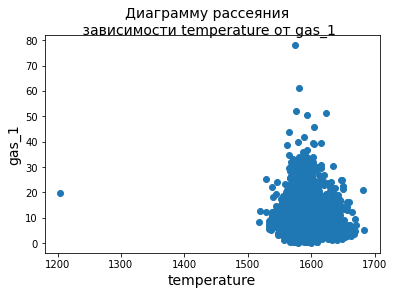

In [46]:
# Найдем корреляцию и построим диаграмму рассеяния для 'temperature', 'gas_1'
scat(new_df_temp['temperature'], new_df_temp['gas_1'], 'temperature', 'gas_1')

Линейная зависимость температуры от подачи газа отсутствует.

### Найдем как зависит температура от полной мощности

In [47]:
# найдем среднюю мощность для каждой партии
new_df_arc = df_arc.pivot_table(index='key', values='full_power', aggfunc='mean')
# объединим данные и удалим пропуски
new_df_temp = new_df_temp.join(new_df_arc['full_power'], how='left')
new_df_temp.dropna(axis=0, inplace = True)
new_df_temp.shape

(3211, 3)

коэффициент пирсона = -0.14305907597511955


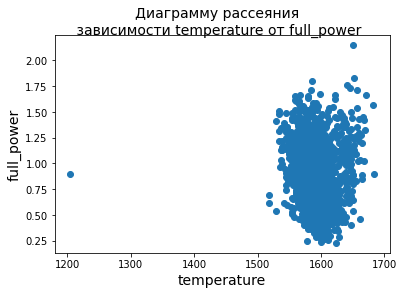

In [48]:
# Найдем корреляцию и построим диаграмму рассеяния для 'temperature', 'full_power'
scat(new_df_temp['temperature'], new_df_temp['full_power'], 'temperature', 'full_power')

Линейной зависимости от средних значений фактически нет. На диаграмме можно наблюдать два выброса. 

### Найдем корреляцию между активной и реактивной мощностью

коэффициент пирсона = 0.9631819131519804


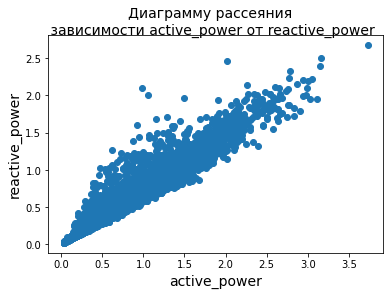

In [49]:
# Найдем корреляцию и построим диаграмму рассеяния для 'active_power', 'reactive_power'
scat(df_arc['active_power'], df_arc['reactive_power'], 'active_power', 'reactive_power')

Линейная зависимость сильная. Обьеденим эти два признака в один.

### Вывод

- Так как сильной корреляции зависимости температуры от остальных признаков не обнаружено, то возможно моделька не похвастается мощными предсказаниями, но мы будем стараться. 
- Построение модели предсказания температуры по всей видимости будем делать по средним значениям/максимальной/минимальной температурой параметров для каждой партии, так как материалы подаются то до, то вовремя, то в начале, то в середине тех процесса, а также замеры мощности проводятся не одновременно с замером температуры.

## Следующие шаги

- Получить ответы на вопросы и после уже с пониманием возможной природы образования нанов и выбросов, корректно провести предобработку (заполнение пропусков, поиск выбросов).
- Провести масштабирование
- Окончательно определится какие признаки взять для обучения модели
- Построить несколько моделей для решения задачи регрессии 
- Выбрать лучшую модель
- Сравнить лучшую модель с константной моделью

## Формируем датасет

### Создадим признаки из датафрейма df_arc

In [50]:
# сгруппируем датафрейм df_arc по ключу 
# создадим пустой датафрейм, куда в дальнейшем будем складывать сгруппированные данные 
df_arc_mean = pd.DataFrame()

# и найдем все уникальные значения key для df_arc
keys_arc = df_arc['key'].sort_values().unique()

# а теперь найдем среднее значение мощностей, время тех процесса в секундах, количество операций, а также работу 
# и сохраним все это в новом датафрейме. 
for key in keys_arc:
    #display(df_arc[df_arc['key'] == keys[key]])
    df = (df_arc[df_arc['key'] == key]).reset_index(drop=True)
    df_arc_mean.loc[key, 'key'] = key
    df_arc_mean.loc[key, 'all_time'] = (df.loc[len(df)-1, 'heating_finish'] - df.loc[0, 'heating_start']).total_seconds()
    df_arc_mean.loc[key, 'active_power'] = df['active_power'].mean()
    df_arc_mean.loc[key, 'reactive_power'] = df['reactive_power'].mean()
    df_arc_mean.loc[key, '%'] = df['%'].mean()
    df_arc_mean.loc[key, 'full_power'] = df['full_power'].mean()
    df_arc_mean.loc[key, 'work'] = df_arc_mean.loc[key, 'full_power'] * df_arc_mean.loc[key, 'all_time']
    df_arc_mean.loc[key,'operations'] = len(df_arc[df_arc['key'] == key])
df_arc_mean.head()

,key,all_time,active_power,reactive_power,%,full_power,work,operations
1,1.0,1583.0,0.975629,0.636648,0.651695,1.165279,1844.636636,5.0
2,2.0,1144.0,0.763150,0.499528,0.645465,0.912304,1043.675889,4.0
3,3.0,1525.0,0.505176,0.319815,0.631751,0.597907,911.807919,5.0
4,4.0,1093.0,0.802313,0.515074,0.641443,0.953741,1042.438469,4.0
5,5.0,1362.0,0.836793,0.563161,0.676904,1.008939,1374.175539,4.0


In [51]:
df_arc_mean.tail()

,key,all_time,active_power,reactive_power,%,full_power,work,operations
3237,3237.0,1350.0,0.786493,0.565692,0.724274,0.968996,1308.145252,5.0
3238,3238.0,910.0,0.702176,0.560394,0.798540,0.898847,817.951094,3.0
3239,3239.0,2930.0,0.583344,0.388952,0.670644,0.701485,2055.352011,8.0
3240,3240.0,3524.0,0.596817,0.496653,0.814330,0.778371,2742.980199,5.0
3241,3241.0,2230.0,0.494289,0.339240,0.677660,0.599903,1337.784045,5.0


In [52]:
# посмотрим на линейные корреляции
for new_column in ['work', 'operations']:
    for old_column in ['all_time', 'active_power', 'reactive_power', '%', 'full_power']:
        print(new_column, ':', old_column, '=', df_arc_mean[new_column].corr(df_arc_mean[old_column]))
    print()

work : all_time = 0.9024572122684431
work : active_power = 0.3931425845602192
work : reactive_power = 0.3885212893530242
work : % = -0.007972450121173034
work : full_power = 0.3985939135104881

operations : all_time = 0.6841378339412192
operations : active_power = -0.008514308810188977
operations : reactive_power = -0.01511938239764204
operations : % = -0.024203174787766405
operations : full_power = -0.009436345799147478



Как оказалось, работа больше зависит от времени, чем от мощностей. Зависимость работы от любой из мощностей приблизительно одинаковая и скажем так слабая, а от процентного соотношением между активной и реактивной мощности зависимости нет вообще.

Есть зависимость между общим временем и количеством операций, что в целом логично. С остальными признаками корреляция отсутствует вовсе.

In [53]:
# Так как оба признака коррелируют со временем, то проверим какая связь между ними двумя 
df_arc_mean['work'].corr(df_arc_mean['operations'])

0.5515996517687998

Не сильная, но и не совсем слабая. 

In [54]:
# посмотрим еще как зависимость между полной мощностью и временем. 
df_arc_mean['full_power'].corr(df_arc_mean['all_time'])

0.0629238219137864

Зависимость отсутствует.

### Создадим признаки из датафрейма df_bulk

Так как в данных о времени подачи сыпучих материалов есть всего одна запись(хотя в тех процессе расписано, что подаваться может в несколько этапов), то значит будем считать, что они подаются все вместе одновременно и едино разово. Поэтому, предлагаю тогда считать, что это подача 1-го плюс минус одинакового по теплоемкости материала. Следовательно, возьмем сумму всех сыпучих материалов, за один признак.

In [55]:
# найдем общую сумму подачи сыпучих материалов 
df_bulk['all_bulk'] = (df_bulk['bulk_1'] + df_bulk['bulk_2'] + df_bulk['bulk_3'] + df_bulk['bulk_4'] + df_bulk['bulk_5'] +
                       df_bulk['bulk_6'] + df_bulk['bulk_7'] + df_bulk['bulk_8'] + df_bulk['bulk_9'] + df_bulk['bulk_10'] +
                       df_bulk['bulk_11'] + df_bulk['bulk_12'] + df_bulk['bulk_13'] + df_bulk['bulk_14'] + df_bulk['bulk_15'])
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,all_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


### Создадим признаки из датафрейма df_temp

На сколько я понял из консультации, необходимо брать среднюю температуру по одному ключу. Если честно, у меня, наверное, до сих пор, есть вопросы по поводу предоставленных данных заказчиком и как заказчик собирается ими воспользоваться для достижения своих целей. Наверное, я еще оставлю свои мысли, как я все это представлю и вижу, только попозже. А пока хочется посмотреть данные о температуре еще более подробно.

<AxesSubplot:>

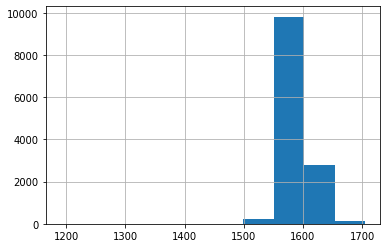

In [56]:
# посмотрим на распределение температуры 
df_temp['temperature'].hist()

<AxesSubplot:>

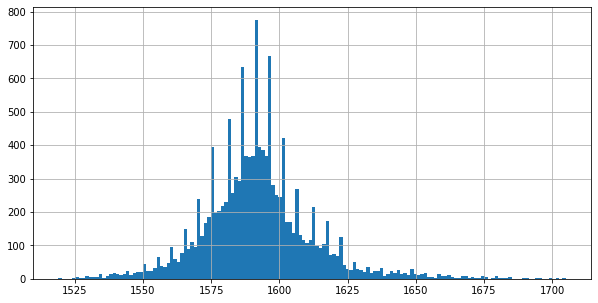

In [57]:
# посмотрим на самый объёмный и информативный интервал 
# (для того чтобы график лучше воспринимался, исключим первые 5 значений температуры)
df_temp[df_temp['temperature'] > 1500]['temperature'].hist(bins=150, figsize=(10,5))

Распределение температуры похоже на нормальное распределение. Имеет форму купола, но с характерными всплесками. Причем есть ощущение, что эти всплески допустим кратны 5-ти или имеют относительно целое число. Возможно это температура нагрева, но скорее всего это стартовая температура или температура поддержания, которая должна быть стабильной, известной и заданной программно, да и плюс ко всему она, наверное, должна быть самой продолжительной по времени, что и объясняет всплески.

<AxesSubplot:>

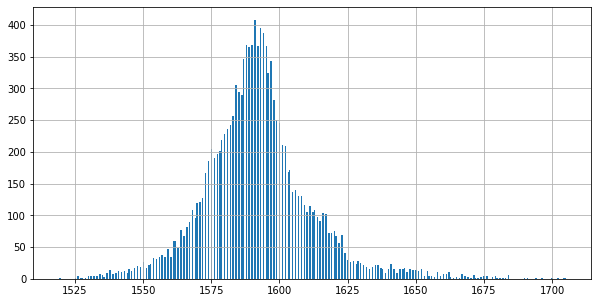

In [58]:
# посмотрим еще более подробно
df_temp[df_temp['temperature'] > 1500]['temperature'].hist(bins=350, figsize=(10,5))

Теперь всплески превратились в сгустки, думаю это те температуры, в которые старается вернуться система после нагрева или охлаждения, так как сказать заданные настройками тех процесса.

<AxesSubplot:>

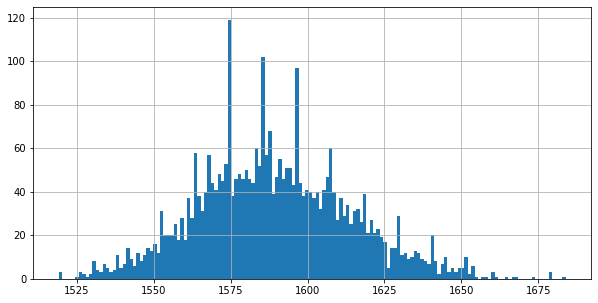

In [59]:
# посмотрим на стартовые температуры
# найдем индексы первой температуры для каждого ключа
index_key_first_temp = []
for key in keys_temp:
    index_key_first_temp.append(df_temp[df_temp['key'] == key].index[0])
df_first_temp = pd.DataFrame(data=df_temp, index=index_key_first_temp)
df_first_temp[df_first_temp['temperature'] > 1500]['temperature'].hist(bins=150, figsize=(10,5))

Ну да, всплески находятся приблизительно в тех же местах. Наверное, версия что эта основана температура (стартовая, перемешивания) тех процесса, та от которой далее будет начинаться нагрев, перед добавлением легирующих материалов и продувки сплава инертным газом.

Перед тем как создадим признаки из данных хранящихся в df_temp, хочу поделиться некоторыми своими мыслями.

        На мой взгляд, данные предоставленные заказчиком немного странные. И мне не понятен тот факт, как он собирается при помощи этих данных решить свою проблему. Как я уже и писал раннее свои предположения: если, например, нагрев распределяется не равномерно по замесу в ковше, а проводить замер температуры возможно только в определённых местах и затраты на электроэнергию для нагрева существенные и если нам надо их сэкономить, то не мешало бы знать более точное время нагрева примеси от одной температуры до другой. В этом случае у нас есть несколько ключевых факторов, это изначальная температура, конечная температура, мощность при которой идет нагрев и время, за которое смесь прогревается, а также начальные, конечные и промежуточные значения параметров тех процесса снятых синхронно. И тогда допустим в этом случае мы вышли на режим. Берем пробу. Получаем результаты. Знаем в каком количестве и что именно нам необходимо добавить. Знаем или предсказываем на какую температуру смесь остынет или на какую температуру необходимо ее поднять, чтобы после того как мы добавим компоненты, температура в ковше была необходимая. Соответственно зная сколько было, сколько должно стать, начинаем нагрев, а так как у нас процесс с большой инерционности, то чтобы исключить ненужный перелет температуры и плавно выйти на режим, сократив колебания температуры и само время продолжительности этапа стабилизации температуры мы делаем предсказание как долго и какую мощность нам необходимо обеспечить на графитовых электродах, чтобы получить минимальные затраты электроэнергии. 
        На данный момент мы видим, что замер температуры проходит в одно время, показания мощности предоставлены в другое. И мы имеем такую картину, что сыпучие материалы добавляем в одно время, замер температуры делаем в другое, (к этому времени смесь уже возможно успела и остыть, и нагреться заново), потом добавляются проволочные материалы и после того как добавили, получаем показатели мощностей. И я немного не понимаю, как заказчик собирается пользоваться предсказаниями? Так как часть данных, особенно по затратам отсутствует. И возможно у нас вообще нет данных о реальной максимальной мощности, а также и температуре. Часть важных данных попросту отсутствует, и как мне кажется, вполне реальна такая картина, что если мы рассчитаем  затраты на электроэнергию в рамках одного месяца исходя из данных предоставленных заказчиком и сравним их с показателями со счётчика, то возможно в жировке будет цифра гораздо больше.  (Просто пока в моей голове это выглядит приблизительно так: к примеру, у нас есть данные о количестве посетителей кафе за ужином, блюда которые заказывали на завтрак, а предсказать нам необходимо меню на обед.). Так как мне кажется, что для каждой строки датасета нам необходимо собрать такие признаки как, текущая температура, текущая мощность, текущий объем смеси, так как это на мой взгляд должны быть признаки для одного события, а если мы имеем в датасете признаки из разных временных отрезков, то, наверное, это данные из разных событий. 
        Было бы, наверное, неплохо объединить данные по текущему времени. Но тогда у нас будет куча пропусков, которые необходимо будет чем-то заполнять. Но если бы получилось собрать такой датасет, то тогда мы бы более точно знали все параметры отправной точки и могли бы делать предсказания, что нам необходимо сделать для того, чтобы оказаться в финальной точке. По факту у нас бы в таргете была разница между текущей и необходимой температурой. А модель исходя из текущих данных или ожидаемых (если вскоре добавить примеси, то и температура вскоре измениться) делала предсказания о работе, которую необходимо было бы проделать. 
        А сейчас нам по всей видимости (исходя из консультации) придется делать предсказания конечной температуры исходя из начальной температуры и по “усредненным” значениях нескольких событий объединённых по номеру партии в одно событие. Далее мы создадим модель, обучим ее, получим хорошие показатели метрики. Но будет ли эта модель полезна заказчику?  Что будет тогда, когда заказчик загрузит в нее данные об объекте за текущие время. Просто мне кажется не логично ждать пока все операции тех процесса пройдут, и он загрузит данные в модель и получит предсказания, в тот момент, когда он уже собственно знает реальные показания. На мой взгляд, было бы лучше делать предсказания разбив датасет на разные события. Например, что будет, когда мы добавим те или иные и в каком количестве сыпучие материалы или проволоку? Как повлияет продувка инертными газами? Сколько необходимо греть смесь чтобы четко выйти на необходимую температуру? Но что есть, то есть. Им там скорее всего яснее, и скорее всего уверено знают, что и как они там будут делать и с какими проблемами встречаются.   
        А возможно основная проблема и есть в том, что они не могут делать синхронный замер параметров. И если бы он был, то они бы и сами все рассчитали без нашей помощи. А так мол ситуация патовая и приходится прибегать к нестандартным для них методам решений проблемы и искать помощи и выходы из ситуации на стороне. Ну а может быть сам замер проводить проблемно и очень долго или датчик постоянно ломается и проще температуру предсказывать, чем проводить измерения.

In [60]:
# создадим пустой датафрейм, куда в дальнейшем будем складывать сгруппированные данные 
df_temperature = pd.DataFrame()
i = 0
# найдем первую и последнюю температуру 
for key in keys_temp:
    df = (df_temp[df_temp['key'] == key]).reset_index(drop=True)
    # убедимся, что для партии есть более одной записи, а также что первая и последняя запись не NaN
    if (len(df) > 1) & (df.loc[0, 'temperature'] >=0) & (df.loc[len(df)-1, 'temperature'] >= 0):
        df_temperature.loc[i, 'key'] = df.loc[0, 'key']
        df_temperature.loc[i, 'first_temperature'] = df.loc[0, 'temperature']
        df_temperature.loc[i, 'last_temperature'] = df.loc[len(df)-1, 'temperature']
        i += 1
df_temperature.head()

,key,first_temperature,last_temperature
0,1.0,1571.0,1613.0
1,2.0,1581.0,1602.0
2,3.0,1596.0,1599.0
3,4.0,1601.0,1625.0
4,5.0,1576.0,1602.0


### Создадим признаки из датафрейма df_bulk

По аналогии с сыпучими материалами, создадим один общий признак по сумме масс.

In [61]:
# найдем общую сумму подачи проволочных материалах
df_wire['all_wire'] = (df_wire['wire_1'] + df_wire['wire_2'] + df_wire['wire_3'] + df_wire['wire_4'] + df_wire['wire_5'] +
                       df_wire['wire_6'] + df_wire['wire_7'] + df_wire['wire_8'] + df_wire['wire_9'])
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,all_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### Соберём признаки 

In [62]:
# соберём все воедино 
df_all = df_temperature.copy()
df_all = df_all.merge(df_arc_mean, how='inner')
df_all = df_all.merge(df_gas, how='inner')
df_all = df_all.merge(df_bulk, how='inner')
df_all = df_all.merge(df_wire, how='inner')

# теперь можно создать еще один признак 
df_all['bwgo'] = (df_all['all_bulk'] + df_all['all_wire'] + df_all['gas_1'])/df_all['operations']

# Столбец key нам больше не нужен
df_all.drop('key', axis=1, inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2329 non-null   float64
 1   last_temperature   2329 non-null   float64
 2   all_time           2329 non-null   float64
 3   active_power       2329 non-null   float64
 4   reactive_power     2329 non-null   float64
 5   %                  2329 non-null   float64
 6   full_power         2329 non-null   float64
 7   work               2329 non-null   float64
 8   operations         2329 non-null   float64
 9   gas_1              2329 non-null   float64
 10  bulk_1             2329 non-null   float64
 11  bulk_2             2329 non-null   float64
 12  bulk_3             2329 non-null   float64
 13  bulk_4             2329 non-null   float64
 14  bulk_5             2329 non-null   float64
 15  bulk_6             2329 non-null   float64
 16  bulk_7             2329 

- Типы данных в целом нас устраивают

In [63]:
# проверим дубликаты
df_all.duplicated().sum()

0

тут все хорошо

### Узнаем как корелируют признаки с целевым

In [64]:
# получим названия признаков
features = list(df_all.columns)
#print(features)
#features.remove('key')
features.remove('last_temperature')
#features

коэффициент пирсона = 0.252443483764898


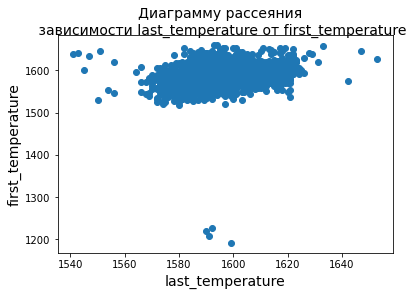

коэффициент пирсона = 0.11205162355609417


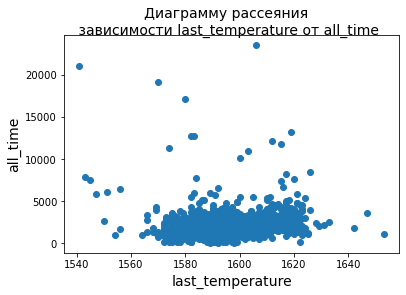

коэффициент пирсона = 0.21106973813396515


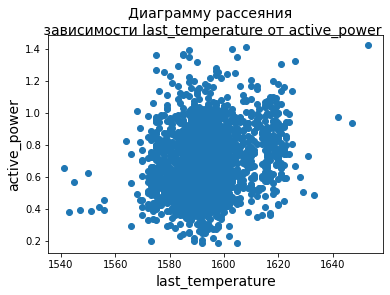

коэффициент пирсона = 0.14993150579095116


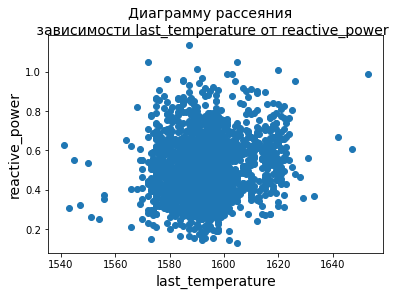

коэффициент пирсона = -0.15286331523725402


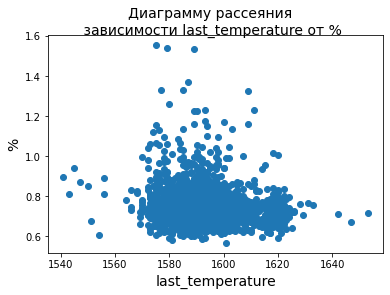

коэффициент пирсона = 0.19102688139136573


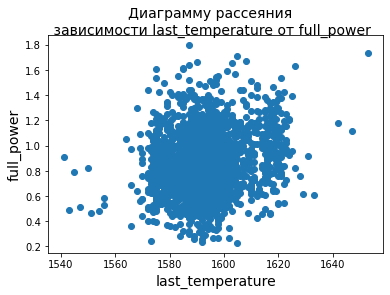

коэффициент пирсона = 0.17813654151551336


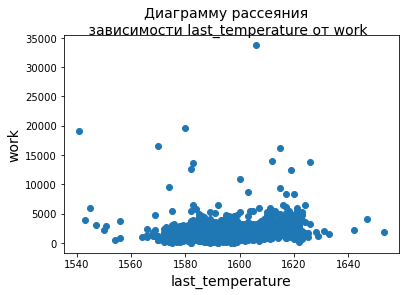

коэффициент пирсона = 0.181145646138802


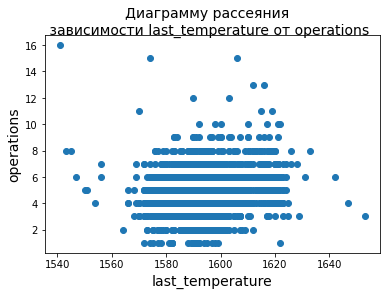

коэффициент пирсона = 0.05916021049982486


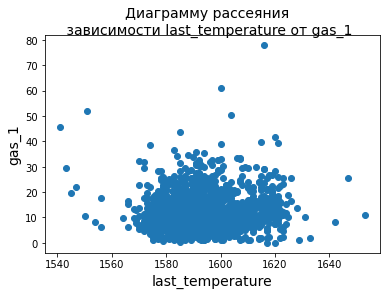

коэффициент пирсона = -0.0752063160383453


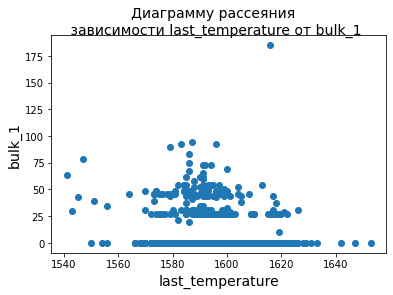

коэффициент пирсона = -0.0824541393360669


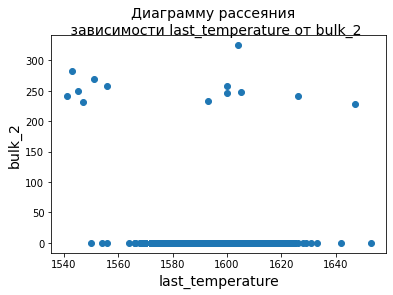

коэффициент пирсона = -0.03597680565518193


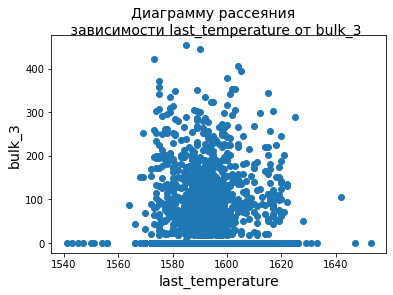

коэффициент пирсона = 0.1879696523324232


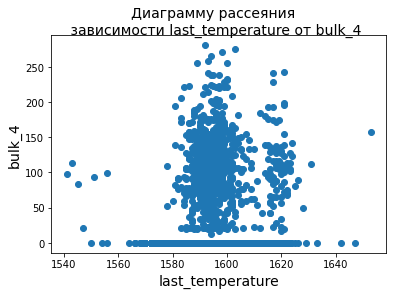

коэффициент пирсона = -0.02835508999153328


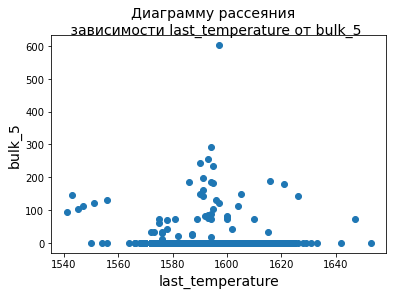

коэффициент пирсона = -0.1818162938846632


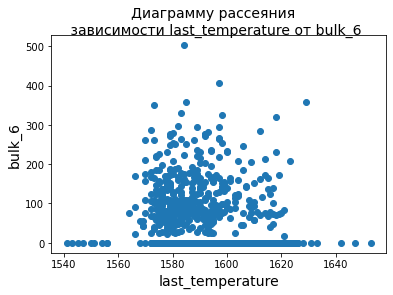

коэффициент пирсона = -0.10727523369020119


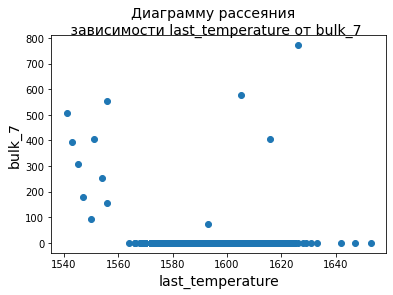

коэффициент пирсона = -0.026586781362368396


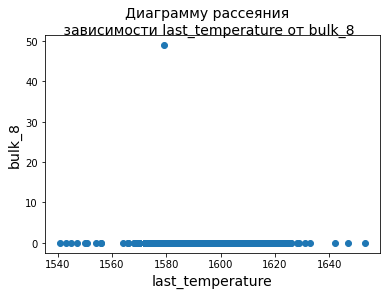

коэффициент пирсона = -0.016075353072374735


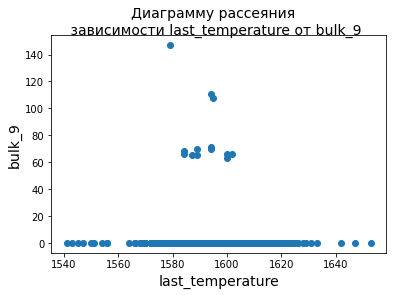

коэффициент пирсона = 0.06134979600660924


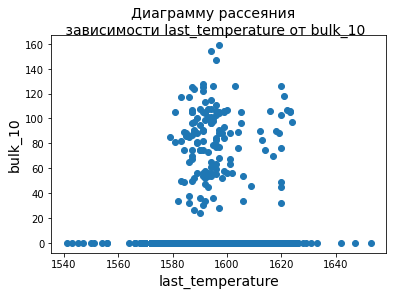

коэффициент пирсона = -0.1147534423962007


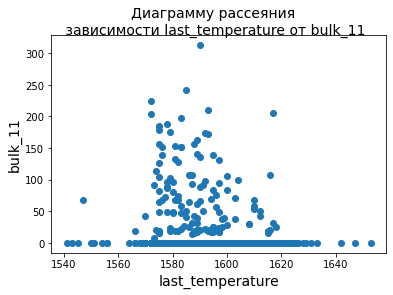

коэффициент пирсона = 0.267424168597636


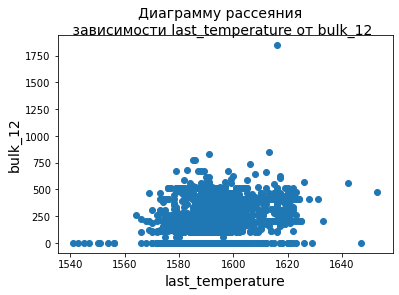

коэффициент пирсона = -0.010919940470578066


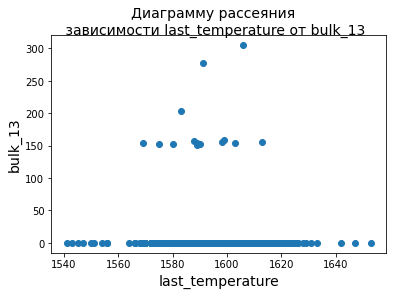

коэффициент пирсона = 0.11461728871026407


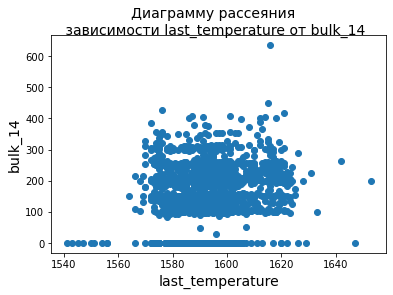

коэффициент пирсона = 0.26641406109426574


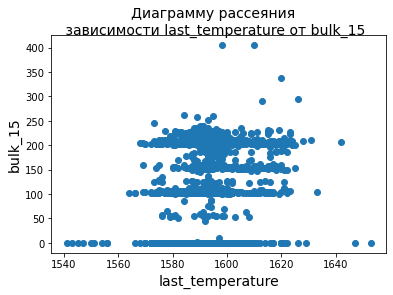

коэффициент пирсона = 0.2226576642308671


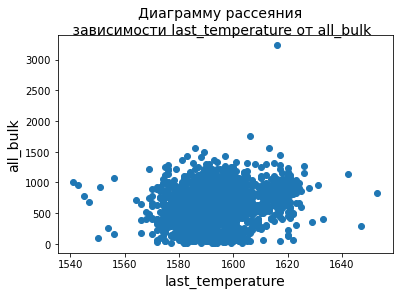

коэффициент пирсона = 0.3175752553418542


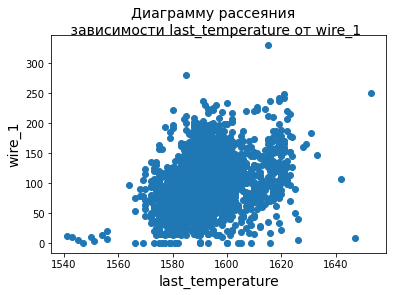

коэффициент пирсона = -0.20667155956358835


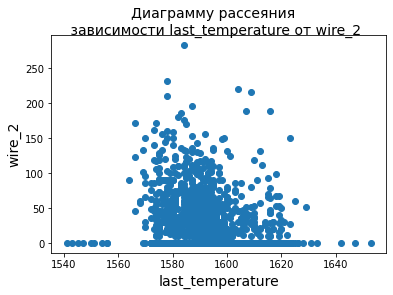

коэффициент пирсона = -0.04753656920764121


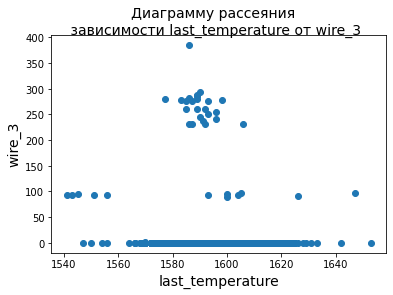

коэффициент пирсона = -0.15971861665473513


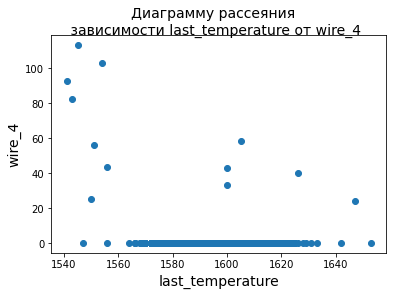

коэффициент пирсона = nan


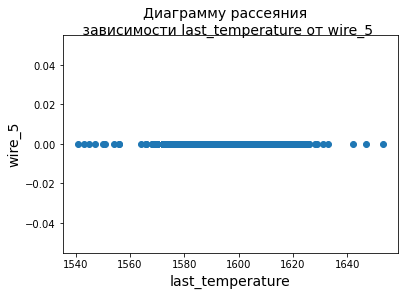

коэффициент пирсона = -0.08403400564317458


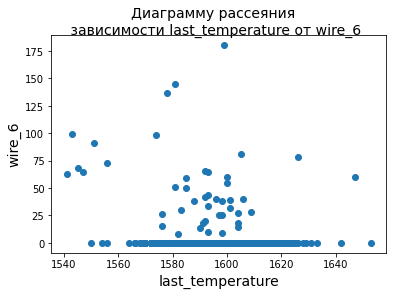

коэффициент пирсона = -0.1372617131015234


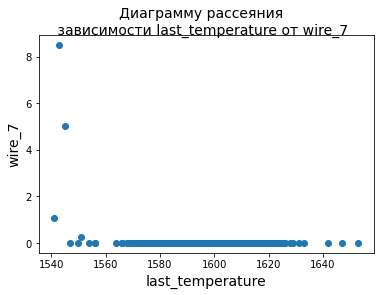

коэффициент пирсона = -0.010766580778981955


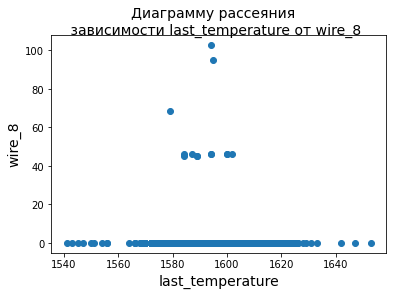

коэффициент пирсона = -0.027488013364657227


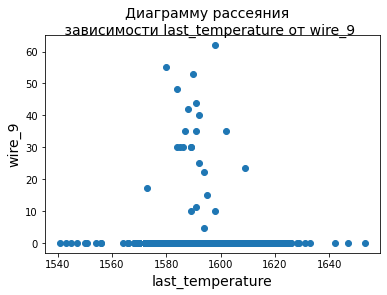

коэффициент пирсона = 0.06106062707498306


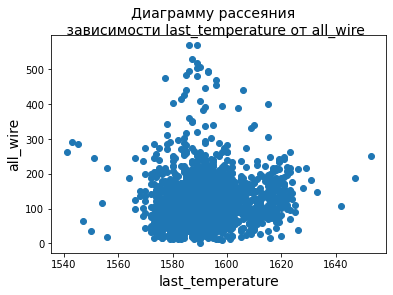

коэффициент пирсона = 0.04268930667356308


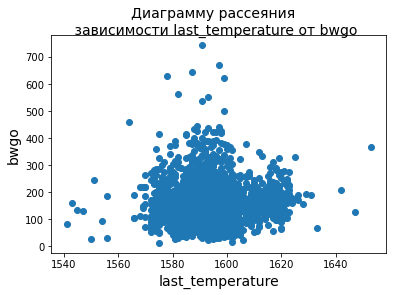

In [65]:
# найдем корреляцию и построим диаграмму рассеяна
for column in features:
    scat(df_all['last_temperature'], df_all[column], 'last_temperature', column)

Сильных линейных зависимостей не наблюдается. Я бы сказал, что тут просматривается где-то пять классов. Которые делятся по температурам где-то в диапазонах: 1540-1550, 1570-1635, 1640-1665, 1670-1690 и 1700. Возможно это связано с добавлением определенных примесей или каких-то подобных групп тех процесса. Наверное этим можно как-то воспользоваться, для улучшения метрики, но я пока не знаю как)) 

Так как самая сильная линейная зависимость равна 0.37, то линейные модели использовать не будем. 

### Разбитие данных на тренировочную и тестовую выборку

In [66]:
# разобьем данные на обучающую и тестовую выборку в соотношении 3:1
df_train, df_test = train_test_split(df_all, test_size=0.25, random_state=12345)

# поделим выборки на features и target
df_train_features = df_train.drop(['last_temperature'], axis=1)
df_train_target = df_train['last_temperature']
df_test_features = df_test.drop(['last_temperature'], axis=1)
df_test_target = df_test['last_temperature']

# проверим размерность выборок
print(df_train_features.shape)
print(df_train_target.shape)
print(df_test_features.shape)
print(df_test_target.shape)

(1746, 36)
(1746,)
(583, 36)
(583,)


### Вывод

- Провели анализ зависимости температуры от остальных признаков
- Выявили сильные линейные зависимости
- Удалили подозрительные партии 
- Создали дополнительные признаки
- Сформировали features и target

## Создание и обучение моделей

### Модель RandomForestRegressor

In [82]:
# создадим модель случайного леса 
model = RandomForestRegressor(random_state=12345)
# укажим гиперпараметров для подбора лучших из их 
parameters = {'max_depth':range(15), 'n_estimators':range(100, 1001, 100)}
# произведем поиск лучших гиперпараметров
grid = RandomizedSearchCV(model, parameters, scoring='neg_mean_absolute_error', 
                         cv=5, n_jobs=-1, random_state=12345, n_iter = 100)
grid.fit(df_train_features, df_train_target)
print('Лучшие гиперпараметры ==>',grid.best_params_)
print('Значение MAE ==>', grid.best_score_)

Лучшие гиперпараметры ==> {'n_estimators': 700, 'max_depth': 14}
Значение MAE ==> -6.216470411920815


При помощи модели RandomForestRegressor удалось добиться значения метрики МАЕ = 6.21
При значениях гиперпараметров: max_depth = 14, n_estimators = 700.

### Модель CatBoostRegressor

In [78]:
# создадим модель CatBoost
model = CatBoostRegressor(iterations=100, loss_function='MAE', 
                          eval_metric='MAE', random_state=12345)

# произведем поиск лучшего значения гиперпараметра learning_rate
parameters = {'learning_rate':arange(0.1, 1.1, 0.1)}
cat = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cat.fit(df_train_features, df_train_target)
print('Лучший параметр ==>', cat.best_params_)
print('Значение MAE ==>', cat.best_score_)

0:	learn: 7.8250849	total: 22.8ms	remaining: 2.26s
1:	learn: 7.6759726	total: 38.4ms	remaining: 1.88s
2:	learn: 7.5135901	total: 51.8ms	remaining: 1.68s
3:	learn: 7.3576207	total: 63.9ms	remaining: 1.53s
4:	learn: 7.2403741	total: 76ms	remaining: 1.44s
5:	learn: 7.0932036	total: 88.1ms	remaining: 1.38s
6:	learn: 6.9972789	total: 99.8ms	remaining: 1.32s
7:	learn: 6.9386168	total: 112ms	remaining: 1.28s
8:	learn: 6.8116207	total: 123ms	remaining: 1.25s
9:	learn: 6.7028686	total: 135ms	remaining: 1.22s
10:	learn: 6.6204119	total: 147ms	remaining: 1.19s
11:	learn: 6.5332926	total: 159ms	remaining: 1.16s
12:	learn: 6.4631121	total: 171ms	remaining: 1.14s
13:	learn: 6.4090001	total: 183ms	remaining: 1.12s
14:	learn: 6.3360531	total: 194ms	remaining: 1.1s
15:	learn: 6.2846557	total: 217ms	remaining: 1.14s
16:	learn: 6.2452838	total: 253ms	remaining: 1.23s
17:	learn: 6.1901274	total: 266ms	remaining: 1.21s
18:	learn: 6.1297643	total: 280ms	remaining: 1.19s
19:	learn: 6.0799010	total: 296ms	rem

In [79]:
# создадим модель CatBoost
model = CatBoostRegressor(iterations=100, learning_rate = 0.1, 
                          loss_function='MAE', eval_metric='MAE', random_state=12345)

# произведем поиск лучшего значения гиперпараметра depth
parameters = {'depth':range(1, 10)}
cat = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cat.fit(df_train_features, df_train_target)
print('Лучший параметр ==>', cat.best_params_)
print('Значение MAE ==>', cat.best_score_)

0:	learn: 7.8335042	total: 10.4ms	remaining: 1.03s
1:	learn: 7.6869406	total: 23.3ms	remaining: 1.14s
2:	learn: 7.5603690	total: 35.7ms	remaining: 1.15s
3:	learn: 7.4738265	total: 46.5ms	remaining: 1.12s
4:	learn: 7.3807469	total: 56.1ms	remaining: 1.06s
5:	learn: 7.2790813	total: 63.2ms	remaining: 991ms
6:	learn: 7.1868180	total: 70.8ms	remaining: 941ms
7:	learn: 7.1300935	total: 77.8ms	remaining: 894ms
8:	learn: 7.0795057	total: 87.6ms	remaining: 886ms
9:	learn: 6.9948767	total: 99.2ms	remaining: 892ms
10:	learn: 6.8898367	total: 109ms	remaining: 885ms
11:	learn: 6.8452742	total: 121ms	remaining: 887ms
12:	learn: 6.7781218	total: 134ms	remaining: 897ms
13:	learn: 6.6982138	total: 144ms	remaining: 885ms
14:	learn: 6.6305811	total: 154ms	remaining: 872ms
15:	learn: 6.5522511	total: 163ms	remaining: 854ms
16:	learn: 6.5232507	total: 173ms	remaining: 845ms
17:	learn: 6.4591791	total: 183ms	remaining: 835ms
18:	learn: 6.3926639	total: 198ms	remaining: 842ms
19:	learn: 6.3426640	total: 216

In [80]:
# создадим модель CatBoost
model = CatBoostRegressor(iterations=100, depth = 5, learning_rate = 0.1, 
                          loss_function='MAE', eval_metric='MAE', random_state=12345)

# произведем поиск лучшего значения гиперпараметра iterations
parameters = {'iterations':range(100, 1001, 100)}
cat = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cat.fit(df_train_features, df_train_target)
print('Лучший параметр ==>', cat.best_params_)
print('Значение MAE ==>', cat.best_score_)

0:	learn: 7.8335042	total: 11.3ms	remaining: 11.3s
1:	learn: 7.6869406	total: 20.1ms	remaining: 10s
2:	learn: 7.5603690	total: 30.6ms	remaining: 10.2s
3:	learn: 7.4738265	total: 39.3ms	remaining: 9.78s
4:	learn: 7.3807469	total: 48.4ms	remaining: 9.63s
5:	learn: 7.2790813	total: 58.4ms	remaining: 9.68s
6:	learn: 7.1868180	total: 66.9ms	remaining: 9.49s
7:	learn: 7.1300935	total: 76.7ms	remaining: 9.51s
8:	learn: 7.0795057	total: 85.1ms	remaining: 9.37s
9:	learn: 6.9948767	total: 94.9ms	remaining: 9.39s
10:	learn: 6.8898367	total: 104ms	remaining: 9.33s
11:	learn: 6.8452742	total: 113ms	remaining: 9.29s
12:	learn: 6.7781218	total: 122ms	remaining: 9.23s
13:	learn: 6.6982138	total: 130ms	remaining: 9.19s
14:	learn: 6.6305811	total: 139ms	remaining: 9.13s
15:	learn: 6.5522511	total: 148ms	remaining: 9.12s
16:	learn: 6.5232507	total: 157ms	remaining: 9.1s
17:	learn: 6.4591791	total: 166ms	remaining: 9.06s
18:	learn: 6.3926639	total: 177ms	remaining: 9.16s
19:	learn: 6.3426640	total: 186ms	

- При помощи модели CatBoostRegressor удалось добиться значения метрики МАЕ = 5.68
- При значениях гиперпараметров: learning_rate = 0.1, depth = 5, iterations = 1000.

### Модель  LightGBM

In [70]:
# создадим модель CatBoost    
model = LGBMRegressor(boosting_type='gbdt', objective='regression', metrics='neg_mean_absolute_error',
                          learning_rate=0.1, n_estimators=20, max_depth=6, bagging_fraction = 0.8, feature_fraction = 0.8)

# произведем поиск лучшего значения гиперпараметра learning_rate
params = {'learning_rate': arange(0.1, 1.1, 0.1)}
lgb = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lgb.fit(df_train_features, df_train_target)
print('Лучшие параметры ==>', lgb.best_params_)
print('Значение MAE ==>', lgb.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Лучшие параметры ==> {'learning_rate': 0.30000000000000004}
Значение MAE ==> -5.960922188670839


In [71]:
# создадим модель CatBoost    
model = LGBMRegressor(boosting_type='gbdt', objective='regression', metrics='neg_mean_absolute_error',
                          learning_rate=0.3, n_estimators=20, max_depth=6, bagging_fraction = 0.8, feature_fraction = 0.8)

# произведем поиск лучшего значения гиперпараметра max_depth
params = {'max_depth': range(1, 10, 1), 'num_leaves':range(5, 100, 5)}
lgb = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lgb.fit(df_train_features, df_train_target)
print('Лучшие параметры ==>', lgb.best_params_)
print('Значение MAE ==>', lgb.best_score_)

Лучшие параметры ==> {'max_depth': 7, 'num_leaves': 35}
Значение MAE ==> -5.9636707839567675


In [72]:
# создадим модель CatBoost    
model = LGBMRegressor(boosting_type='gbdt', objective='regression', metrics='neg_mean_absolute_error',
                      learning_rate=0.3, n_estimators=20, max_depth=7, bagging_fraction = 0.8, 
                      feature_fraction = 0.8, num_leaves = 35)

# произведем поиск лучшего значения гиперпараметра n_estimators
params = {'n_estimators':range(100, 1001, 100)}
lgb = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lgb.fit(df_train_features, df_train_target)
print('Лучшие параметры ==>', lgb.best_params_)
print('Значение MAE ==>', lgb.best_score_)

Лучшие параметры ==> {'n_estimators': 100}
Значение MAE ==> -6.0755559183514025


In [73]:
# создадим модель CatBoost    
model = LGBMRegressor(boosting_type='gbdt', objective='regression', metrics='neg_mean_absolute_error',
                      learning_rate=0.3, n_estimators=100, max_depth=7, bagging_fraction = 0.8, 
                      feature_fraction = 0.8, num_leaves = 35)

# произведем поиск лучших значений гиперпараметров bagging_fraction и feature_fraction
params = {'bagging_fraction':arange(0.1, 1.1, 0.1), 'feature_fraction':arange(0.1, 1.1, 0.1)}
lgb = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lgb.fit(df_train_features, df_train_target)
print('Лучшие параметры ==>', lgb.best_params_)
print('Значение MAE ==>', lgb.best_score_)

Лучшие параметры ==> {'bagging_fraction': 0.1, 'feature_fraction': 0.6}
Значение MAE ==> -6.018742754118982


In [74]:
# создадим модель CatBoost    
model = LGBMRegressor(boosting_type='gbdt', objective='regression', metrics='neg_mean_absolute_error',
                      learning_rate=0.3, n_estimators=100, max_depth=7, bagging_fraction = 0.1, 
                      feature_fraction = 0.6, num_leaves = 35)

# произведем поиск лучших значений гиперпараметров max_bin и min_data_in_leaf
params = {'max_bin': range(5, 256, 10), 'min_data_in_leaf':range(1, 102, 10)}
lgb = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lgb.fit(df_train_features, df_train_target)
print('Лучшие параметры ==>', lgb.best_params_)
print('Значение MAE ==>', lgb.best_score_)

Лучшие параметры ==> {'max_bin': 75, 'min_data_in_leaf': 91}
Значение MAE ==> -5.890553389550229


- При помощи модели LGBMRegressor удалось добиться значения метрики МАЕ = 5.89
- При значениях гиперпараметров: learning_rate=0.3, n_estimators=100, max_depth=7, bagging_fraction = 0.1, feature_fraction = 0.6, num_leaves = 35, max_bin = 75, min_data_in_leaf = 91

## Проверка лучшей модели на тестовой выборке

In [81]:
# создадим модель CatBoost с гиперпараметрами, при которых удалось добиться лучшего результата метрики МАЕ
model = CatBoostRegressor(iterations=1000, depth = 5, learning_rate = 0.1, 
                          loss_function='MAE', eval_metric='MAE', 
                          random_state=12345).fit(df_train_features, df_train_target)
prediction = model.predict(df_test_features) 
mean_absolute_error(df_test_target, prediction)

0:	learn: 7.8335042	total: 14.3ms	remaining: 14.3s
1:	learn: 7.6869406	total: 21.3ms	remaining: 10.6s
2:	learn: 7.5603690	total: 30.2ms	remaining: 10s
3:	learn: 7.4738265	total: 37.4ms	remaining: 9.3s
4:	learn: 7.3807469	total: 44.6ms	remaining: 8.88s
5:	learn: 7.2790813	total: 51.6ms	remaining: 8.54s
6:	learn: 7.1868180	total: 58.7ms	remaining: 8.33s
7:	learn: 7.1300935	total: 65.5ms	remaining: 8.12s
8:	learn: 7.0795057	total: 72.4ms	remaining: 7.98s
9:	learn: 6.9948767	total: 79.5ms	remaining: 7.87s
10:	learn: 6.8898367	total: 86.5ms	remaining: 7.78s
11:	learn: 6.8452742	total: 93.9ms	remaining: 7.73s
12:	learn: 6.7781218	total: 101ms	remaining: 7.64s
13:	learn: 6.6982138	total: 108ms	remaining: 7.58s
14:	learn: 6.6305811	total: 115ms	remaining: 7.52s
15:	learn: 6.5522511	total: 122ms	remaining: 7.49s
16:	learn: 6.5232507	total: 129ms	remaining: 7.49s
17:	learn: 6.4591791	total: 136ms	remaining: 7.44s
18:	learn: 6.3926639	total: 144ms	remaining: 7.42s
19:	learn: 6.3426640	total: 151m

5.928814812366222

In [77]:
# Проверим качество константной модели  
model = DummyRegressor(strategy="median").fit(df_train_features, df_train_target)
precesion = model.predict(df_test_features)
mean_absolute_error(df_test_target, precesion)

8.332761578044597

### Вывод

- Проведено обучение трех моделей (RandomForestRegressor, CatBoostRegressor и LGBMRegressor)
- Найдена лучшая модель и проверена на тестовых данных 
- Лучшая модель прошла проверку на вменяемость

## Вывод

- В ходе работы над проектом, была выявлена лучшая модель, ей оказалась модель CatBoostRegressor.
- Данная модель показала лучшее значение метрики МАЕ на тренировочных данных равное 5.686
- На тестовых данных значение МАЕ достигнуто в 5.929, что гораздо ниже минимального требования размерности метрики в 8.7
- Модель оказалась довольно стабильной, между тестовыми и тренировочными данными разница оказалась около 4%.
- Значение МАЕ на константной модели равно 8.3, что на четверть больше, чем у нашей модели. 
- Думаю данную модель CatBoostRegressor можно смело предлагать заказчику.